# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(-0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

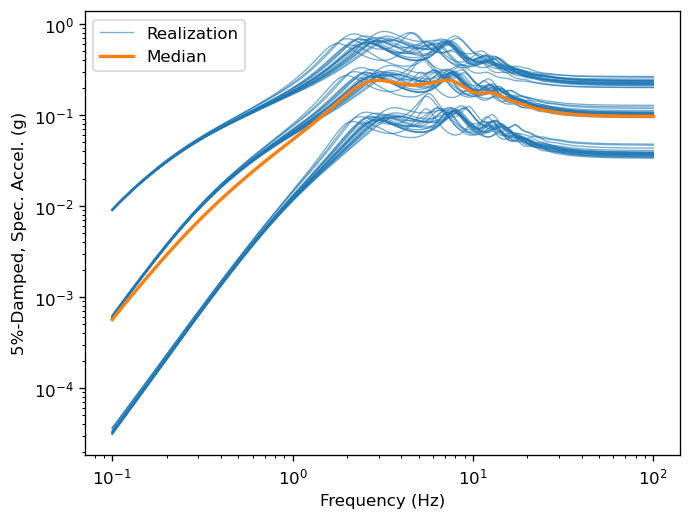

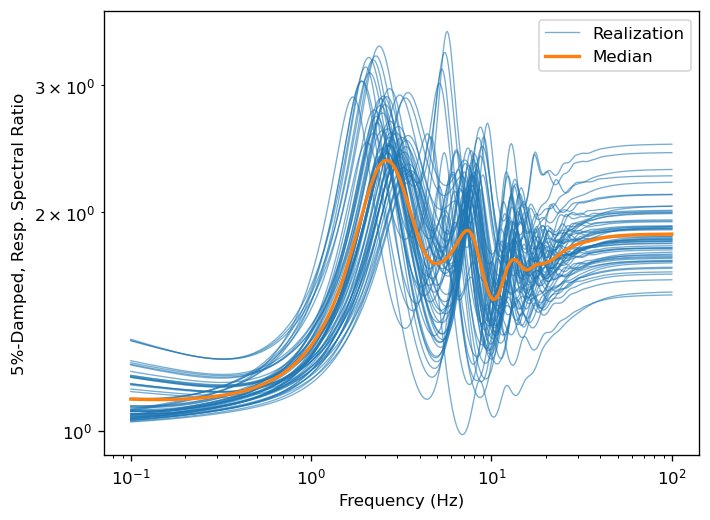

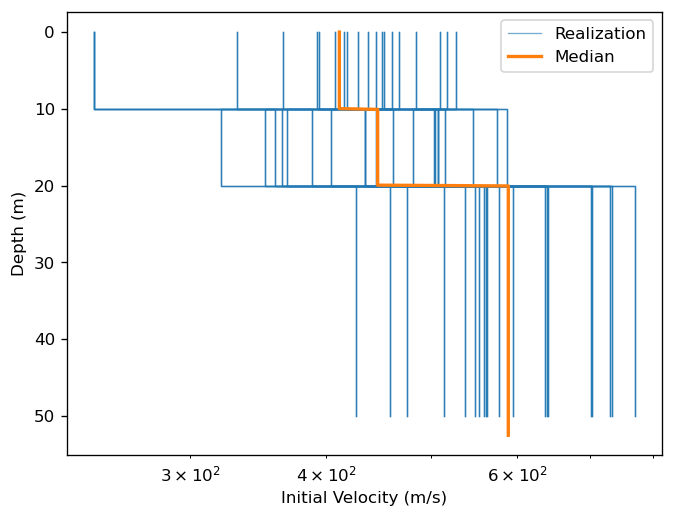

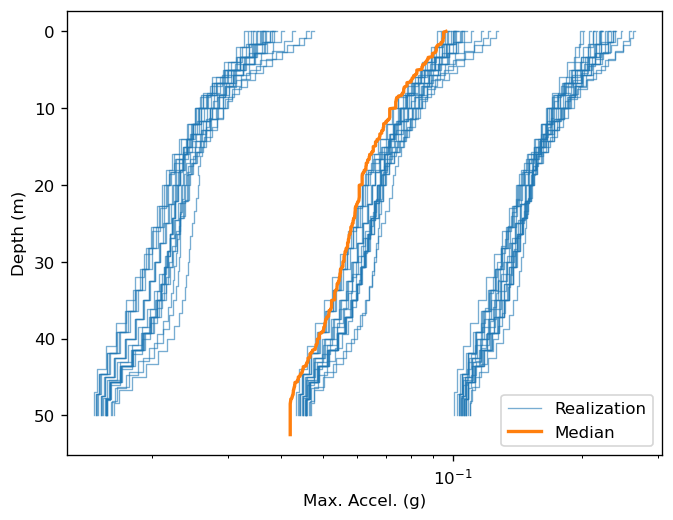

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.131831  1.044961  1.027623  1.184222  1.061808  1.038102   
0.101394    1.131464  1.044944  1.027846  1.183585  1.061765  1.038400   
0.102807    1.131098  1.044931  1.028071  1.182949  1.061727  1.038702   
0.104240    1.130733  1.044922  1.028298  1.182316  1.061694  1.039007   
0.105693    1.130369  1.044917  1.028528  1.181686  1.061665  1.039315   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.946538  1.851650  1.786688  1.775412  1.713618  1.614470   
95.932095   1.946565  1.851665  1.786718  1.775475  1.713677  1.614543   
97.269336   1.946590  1.851680  1.786748  1.775535  1.713733  1.614613   
98.625218   1.946615  1.851695  1.786776  1.775594  1.713788  1.614681   
100.000000  1.946639  1.851709  1.786803  1.775650  1.713841  1.614747   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.190396  1.066504  1.042668  1.187567  ...  1.029758  1.192236   
0.101394    1.189827  1.066460  1.042999  1.186917  ...  1.029997  1.191574   
0.102807    1.189261  1.066421  1.043333  1.186270  ...  1.030238  1.190914   
0.104240    1.188697  1.066387  1.043670  1.185625  ...  1.030482  1.190257   
0.105693    1.188135  1.066357  1.044010  1.184983  ...  1.030728  1.189603   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   2.246581  2.118025  1.997295  1.863170  ...  1.824555  1.912281   
95.932095   2.246655  2.118090  1.997389  1.863221  ...  1.824591  1.912337   
97.269336   2.246726  2.118153  1.997479  1.863270  ...  1.824625  1.912391   
98.625218   2.246794  2.118213  1.997567  1.863317  ...  1.824659  1.912443   
100.000000  2.246861  2.118272  1.997652  1.863364  ...  1.824691  1.912494   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.064545  1.039901  1.331858  1.106975  1.067733  1.330509   
0.101394    1.064499  1.040213  1.330534  1.106858  1.068232  1.329226   
0.102807    1.064458  1.040528  1.329213  1.106748  1.068735  1.327945   
0.104240    1.064422  1.040846  1.327897  1.106644  1.069244  1.326669   
0.105693    1.064391  1.041167  1.326586  1.106547  1.069759  1.325398   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.828017  1.716400  2.418389  2.200863  1.908238  2.483940   
95.932095   1.828070  1.716470  2.418498  2.200986  1.908391  2.484062   
97.269336   1.828121  1.716538  2.418603  2.201105  1.908539  2.484181   
98.625218   1.828171  1.716604  2.418705  2.201220  1.908682  2.484295   
100.000000  1.828219  1.716667  2.418804  2.201331  1.908822  2.484406   

                                
                  m1        m2  
0.100000    1.108528  1.070679  
0.101394    1.108411  1.071192  
0.102807    1.108299  1.071711  
0.104240    1.108194  1.072234  
0.105693    1.108095  1.072763  
...              ...       ...  
94.613238   2.292257  2.040006  
95.932095   2.292391  2.040174  
97.269336   2.292520  2.040338  
98.625218   2.292646  2.040496  
100.000000  2.292768  2.040650  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.131831
0.101394,p0,m0,1.131464
0.102807,p0,m0,1.131098
0.104240,p0,m0,1.130733
0.105693,p0,m0,1.130369
...,...,...,...
94.613238,p19,m2,2.040006
95.932095,p19,m2,2.040174
97.269336,p19,m2,2.040338


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.208234  0.048955
           m1      1.069853  0.017246
           m2      1.043740  0.011510
0.101394   m0      1.207511  0.048749
           m1      1.069798  0.017218
...                     ...       ...
98.625218  m1      1.879656  0.080175
           m2      1.753432  0.073189
100.000000 m0      1.974435  0.093252
           m1      1.879716  0.080179
           m2      1.753510  0.073190

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion").pivot(columns="motion").swaplevel(0, 1, axis=1).sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.048955  1.208234  0.017246  1.069853  0.011510  1.043740
0.101394    0.048749  1.207511  0.017218  1.069798  0.011584  1.044076
0.102807    0.048544  1.206790  0.017191  1.069748  0.011659  1.044415
0.104240    0.048338  1.206071  0.017164  1.069703  0.011735  1.044758
0.105693    0.048133  1.205356  0.017139  1.069664  0.011812  1.045105
...              ...       ...       ...       ...       ...       ...
94.613238   0.093244  1.974172  0.080164  1.879464  0.073188  1.753182
95.932095   0.093246  1.974241  0.080168  1.879530  0.073188  1.753268
97.269336   0.093248  1.974308  0.080172  1.879594  0.073189  1.753351
98.625218   0.093250  1.974372  0.080175  1.879656  0.073189  1.753432
100.000000  0.093252  1.974435  0.080179  1.879716  0.073190  1.753510

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.048955,1.208234
0.101394,0.048749,1.207511
0.102807,0.048544,1.206790
0.104240,0.048338,1.206071
0.105693,0.048133,1.205356
...,...,...
94.613238,0.093244,1.974172
95.932095,0.093246,1.974241
97.269336,0.093248,1.974308


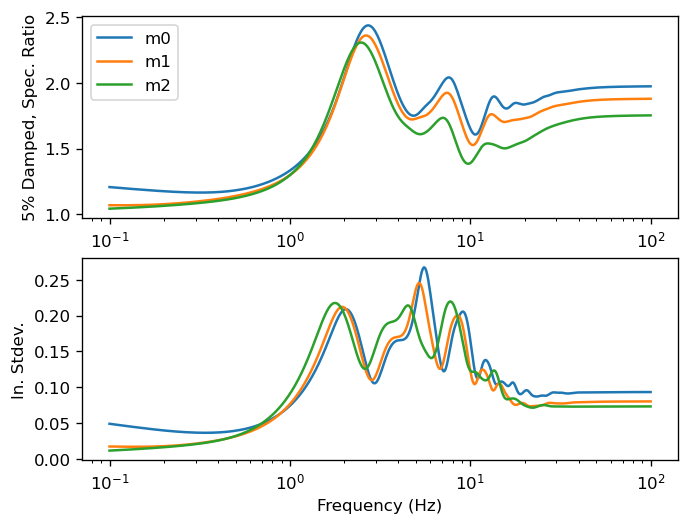

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;